In [1]:
# DEPENDENCIES
if True:
    import george
    from george.modeling import Model
    import numpy as np
    import matplotlib.pyplot as pl
    from george import kernels
    np.random.seed(1234)
    import emcee
    from tqdm import tqdm
%matplotlib inline

In [2]:
# inputs
PLOT_model = True
PLOT = True

RUN_1 = True
burn1 = 500
chain1 = 1000

RUN_2 = True
burn2 = 2000
chain2 = 2000

In [3]:
# Modelos a usar, 3 y 5 ndim
class Model(Model):
    parameter_names = ("amp", "location", "log_sigma2")

    def get_value(self, t):
        return self.amp * np.exp(-0.5*(t.flatten()-self.location)**2 * np.exp(-self.log_sigma2))

class PolynomialModel(Model):
    parameter_names = ("m", "b", "amp", "location", "log_sigma2")
    def get_value(self, t):
        t = t.flatten()
        return (t * self.m + self.b +
                self.amp * np.exp(-0.5*(t-self.location)**2*np.exp(-self.log_sigma2)))
    pass


In [4]:
def generate_data(params, N, rng=(-5, 5)):
    gp = george.GP(0.1 * kernels.ExpSquaredKernel(3.3))
    t = rng[0] + np.diff(rng) * np.sort(np.random.rand(N))
    y = gp.sample(t)
    y += Model(**params).get_value(t)
    yerr = 0.05 + 0.05 * np.random.rand(N)
    y += yerr * np.random.randn(N)
    return t, y, yerr

truth = dict(amp=-1.0, location=0.1, log_sigma2=np.log(0.4))
t, y, yerr = generate_data(truth, 50)

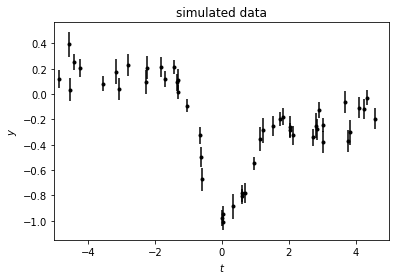

In [5]:
if PLOT_model:
    pl.figure()
    pl.errorbar(t, y, yerr=yerr, fmt=".k", capsize=0)
    pl.ylabel(r"$y$")
    pl.xlabel(r"$t$")
    pl.xlim(-5, 5)
    pl.title("simulated data");


initialize run1
Running burn-in...
Running production...
run 1: ('mean:m', 'mean:b', 'mean:amp', 'mean:location', 'mean:log_sigma2') [-0.0604417  -0.0181886  -0.95892062  0.16856148 -0.97395248]


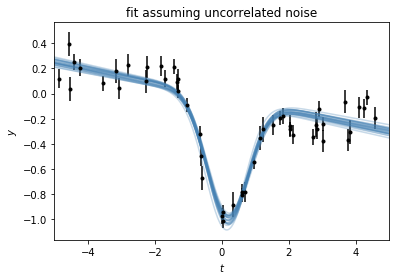

In [9]:
# RUN FOR JUST KERNEL
def lnprob(p):
    model.set_parameter_vector(p)
    return model.log_likelihood(y, quiet=True) + model.log_prior()

if RUN_1:
    print('initialize run1')
    model = george.GP(mean=PolynomialModel(m=0, b=0, amp=-1, location=0.1, log_sigma2=np.log(0.4)))
    model.compute(t, yerr)


    initial = model.get_parameter_vector()
    ndim, nwalkers = len(initial), 32
    p0 = initial + 1e-8 * np.random.randn(nwalkers, ndim)
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob)

    print("Running burn-in...")
    p0, _, _ = sampler.run_mcmc(p0, burn1)
    sampler.reset()

    print("Running production...")
    sampler.run_mcmc(p0, chain1);

    # plot results
    if PLOT:
        # Plot the data.
        pl.figure()
        pl.errorbar(t, y, yerr=yerr, fmt=".k", capsize=0)

        # The positions where the prediction should be computed.
        x = np.linspace(-5, 5, 500)

        # Plot 24 posterior samples.
        samples = sampler.flatchain
        for s in samples[np.random.randint(len(samples), size=24)]:
            model.set_parameter_vector(s)
            pl.plot(x, model.mean.get_value(x), color="#4682b4", alpha=0.3)

        pl.ylabel(r"$y$")
        pl.xlabel(r"$t$")
        pl.xlim(-5, 5)
        pl.title("fit assuming uncorrelated noise");
    print('run 1:', model.get_parameter_names(), model.get_parameter_vector())

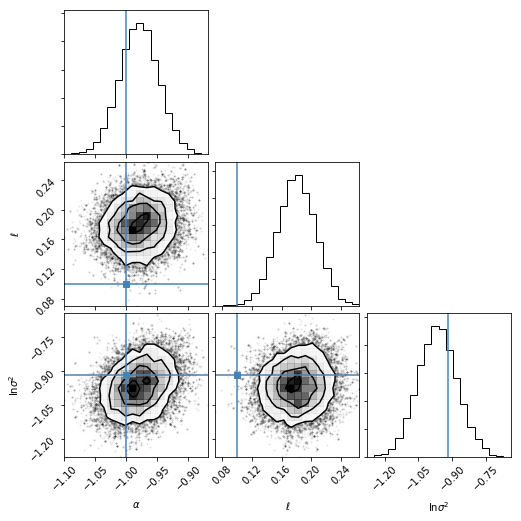

In [7]:
from corner import corner

tri_cols = ["amp", "location", "log_sigma2"]
tri_labels = [r"$\alpha$", r"$\ell$", r"$\ln\sigma^2$"]
tri_truths = [truth[k] for k in tri_cols]
tri_range = [(-2, -0.01), (-3, -0.5), (-1, 1)]
names = model.get_parameter_names()
inds = np.array([names.index("mean:"+k) for k in tri_cols])
corner(sampler.flatchain[:, inds], truths=tri_truths, labels=tri_labels);

In [10]:
kwargs = dict(**truth)
kwargs["bounds"] = dict(location=(-2, 2))
mean_model = Model(**kwargs)
gp = george.GP(np.var(y) * kernels.Matern32Kernel(10.0), mean=mean_model)
gp.compute(t, yerr)

def lnprob2(p):
    gp.set_parameter_vector(p)
    return gp.log_likelihood(y, quiet=True) + gp.log_prior()

print('run 2 pre:', gp.get_parameter_names(), gp.get_parameter_vector())

run 2 pre: ('mean:amp', 'mean:location', 'mean:log_sigma2', 'kernel:k1:log_constant', 'kernel:k2:metric:log_M_0_0') [-1.          0.1        -0.91629073 -2.07142996  2.30258509]


In [11]:
initial = gp.get_parameter_vector()
ndim, nwalkers = len(initial), 32
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob2)

print("Running first burn-in...")
p0 = initial + 1e-8 * np.random.randn(nwalkers, ndim)
p0, lp, _ = sampler.run_mcmc(p0, chain2)

print("Running second burn-in...")
p0 = p0[np.argmax(lp)] + 1e-8 * np.random.randn(nwalkers, ndim)
sampler.reset()
p0, _, _ = sampler.run_mcmc(p0, chain2)
sampler.reset()

print("Running production...")
sampler.run_mcmc(p0, chain2);
print('run 2:', gp.get_parameter_names(), gp.get_parameter_vector())

Running first burn-in...
Running second burn-in...
Running production...
run 2: ('mean:amp', 'mean:location', 'mean:log_sigma2', 'kernel:k1:log_constant', 'kernel:k2:metric:log_M_0_0') [-1.0238659   0.12348898 -0.84699909 -2.95614917  2.64188129]


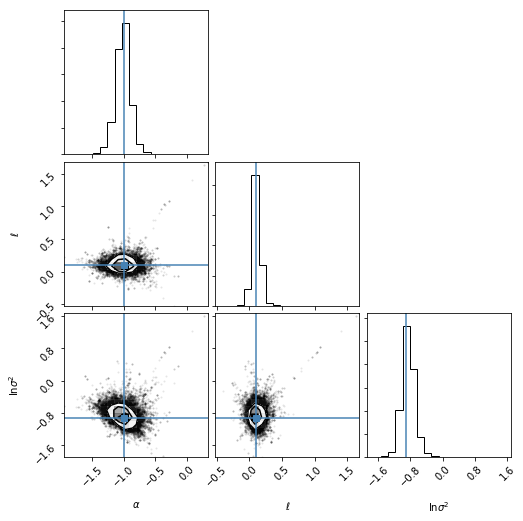

In [13]:
names = gp.get_parameter_names()
inds = np.array([names.index("mean:"+k) for k in tri_cols])
corner(sampler.flatchain[:, inds], truths=tri_truths, labels=tri_labels);

In [14]:
mean_model = Model(**kwargs)

In [21]:
mod = mean_model.get_value(t)
gp1 = george.GP(np.var(y) * kernels.Matern32Kernel(10.0), mean=mod)
gp1.compute(t, yerr)
def lnprob3(p):
    gp1.set_parameter_vector(p)
    return gp1.log_likelihood(y, quiet=True) + gp1.log_prior()

print('run 3 pre:')

initial = gp1.get_parameter_vector()
ndim, nwalkers = len(initial), 32
sampler1 = emcee.EnsembleSampler(nwalkers, ndim, lnprob2)

print("Running first burn-in...")
p0 = initial + 1e-8 * np.random.randn(nwalkers, ndim)
p0, lp, _ = sampler1.run_mcmc(p0, chain2)

print("Running second burn-in...")
p0 = p0[np.argmax(lp)] + 1e-8 * np.random.randn(nwalkers, ndim)
sampler1.reset()
p0, _, _ = sampler1.run_mcmc(p0, chain2)
sampler1.reset()

print("Running production...")
sampler1.run_mcmc(p0, chain2);
print('run 3:')

run 3 pre:


AttributeError: parameter_vector

In [22]:
gp1

In [24]:
gp1.get_parameter_names()

AttributeError: parameter_names